# (G20) LXMERT로 살펴보는 VQA

# 들어가기

# LXMERT 모델구조 복습

In [2]:
# 오늘 실습을 위한 작업디렉토리로 이동합니다.
!cd ~/aiffel/lxmert

from IPython.display import clear_output, Image, display
import PIL.Image
import io
import json
import torch
import numpy as np
from transformers import LxmertForQuestionAnswering, LxmertTokenizer
import wget
import pickle
import os, sys

# 추가해준 모듈을 임포트하기 위해 아래 경로를 path에 추가합니다. 
sys.path.append(os.getenv('HOME')+'/aiffel/lxmert')
from processing_image import Preprocess
from visualizing_image import SingleImageViz
from modeling_frcnn import GeneralizedRCNN
from utils import Config
import utils

print(torch.__version__)

1.8.1+cu102


In [3]:
# object definition
OBJ_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/objects_vocab.txt"
objids = utils.get_data(OBJ_URL)
print(len(objids))
print(objids[:30])  #1600개의 단어사전 중 30개만 출력

1600
['yolk', 'goal', 'bathroom', 'macaroni', 'umpire', 'toothpick', 'alarm clock', 'ceiling fan', 'photos', 'parrot', 'tail fin', 'birthday cake', 'calculator', 'catcher', 'toilet', 'batter', 'stop sign,stopsign', 'cone', 'microwave,microwave oven', 'skateboard ramp', 'tea', 'dugout', 'products', 'halter', 'kettle', 'kitchen', 'refrigerator,fridge', 'ostrich', 'bathtub', 'blinds']


In [4]:
# attribute definition
ATTR_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/attributes_vocab.txt"
attrids = utils.get_data(ATTR_URL)
print(len(attrids))
print(attrids[:30])   #400개의 단어사전 중 30개만 출력

400
['gray,grey', 'multi colored,multi-colored,multicolored', 'double decker,double-decker', 'unmade', 'red', 'camouflage', 'blue', 'white', 'green', 'pink', 'yellow', 'black', 'ivory', 'throwing', 'orange', 'spiky', 'plaid', 'purple', 'soccer', 'brake', 'blonde', 'american', 'flat screen', 'brown', 'wooden', 'performing', 'pulled back', 'windshield', 'bald', 'chocolate']


In [5]:
# VQA answer definition
VQA_URL = "https://raw.githubusercontent.com/airsplay/lxmert/master/data/vqa/trainval_label2ans.json"
vqa_answers = utils.get_data(VQA_URL)
print(len(vqa_answers))
print(vqa_answers[:30])  #3129개의 단어사전 중 30개만 출력

3129
['', 'woods', 'trash can', 'hanging', 'wooden', 'cooking', 'china', 'kids', 'bike rack', 'on phone', 'music', 'travel', 'tulip', 'arrow', 'branch', 'chevron', 'mouth', 'on right', 'rice', 'plate', 'lots', 'nature', 'fruits', 'throwing frisbee', 'blonde', 'life jacket', 'ham', 'hay', 'hat', 'to get to other side']


In [6]:
# 위 이미지의 URL
URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/images/input.jpg"

frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")
image_preprocess = Preprocess(frcnn_cfg)

images, sizes, scales_yx = image_preprocess(URL)

loading configuration file cache


In [7]:
print(images)
print(sizes)

tensor([[[[  37.0199,   32.2233,   25.0255,  ...,  -40.9723,  -31.3756,
            -24.9801],
          [  31.0199,   27.6623,   22.6238,  ...,  -42.1717,  -31.8553,
            -24.9801],
          [  22.0199,   20.8207,   19.0213,  ...,  -43.9708,  -32.5748,
            -24.9801],
          ...,
          [ -85.9802,  -83.9816,  -80.9824,  ...,   71.0138,   63.8164,
             59.0198],
          [ -87.7801,  -85.0620,  -80.9833,  ...,   66.2157,   61.1775,
             57.8199],
          [ -88.9801,  -85.7823,  -80.9838,  ...,   63.0170,   59.4182,
             57.0199]],

         [[  44.0535,   42.4546,   40.0554,  ...,  -27.9406,  -20.7431,
            -15.9465],
          [  49.2535,   44.4569,   37.2591,  ...,  -25.1393,  -16.2624,
            -10.3465],
          [  57.0535,   47.4602,   33.0647,  ...,  -20.9372,   -9.5412,
             -1.9465],
          ...,
          [ -99.9466,  -97.5482,  -93.9492,  ...,   52.0463,   43.6493,
             38.0533],
          [-101.74

In [8]:
test_questions_for_url1 = [
    "Where is this scene?",
    "what is the man riding?",
    "What is the man wearing?",
    "What is the color of the horse?"
]

# 모델 구성(1) F-RCNN

In [9]:
frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")

frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=frcnn_cfg)

loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /home/aiffel-dj20/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.


In [10]:
frcnn_cfg.max_detections  # object detection 모델이 검출할 최대 object 개수

36

In [11]:
output_dict = frcnn(
    images, 
    sizes, 
    scales_yx=scales_yx, 
    padding="max_detections",
    max_detections=frcnn_cfg.max_detections,
    return_tensors="pt"
)

In [12]:
print(output_dict.get("boxes"))
print('-------------')
print(output_dict.get("boxes").shape)

tensor([[[1.6930e+02, 2.1428e+02, 4.8507e+02, 4.6975e+02],
         [1.0072e+02, 2.5157e+02, 3.9440e+02, 4.8000e+02],
         [5.8607e+02, 0.0000e+00, 6.3892e+02, 3.5348e+02],
         [6.0813e+02, 6.1844e+01, 6.3753e+02, 4.2312e+02],
         [2.8151e+02, 1.6208e+02, 3.2836e+02, 1.9436e+02],
         [1.5756e+02, 9.3071e+01, 3.9201e+02, 4.6143e+02],
         [2.2245e+02, 2.9141e+02, 5.6593e+02, 4.8000e+02],
         [4.1366e+01, 1.8160e+02, 3.4989e+02, 4.5049e+02],
         [1.3899e+01, 1.7041e+00, 2.0780e+02, 4.3721e+02],
         [3.8143e+02, 3.1056e+02, 6.1871e+02, 4.1796e+02],
         [2.6148e+02, 1.9268e+02, 3.6299e+02, 4.2911e+02],
         [2.0384e+02, 0.0000e+00, 3.0062e+02, 2.7995e+02],
         [2.9271e+00, 0.0000e+00, 1.2306e+02, 3.5311e+02],
         [2.4660e+02, 1.5944e+02, 3.4745e+02, 3.6034e+02],
         [5.5263e+01, 2.7269e+01, 1.2843e+02, 3.8614e+02],
         [4.4270e-01, 3.3880e+02, 5.0326e+02, 4.7818e+02],
         [1.7163e+02, 3.7074e+02, 4.6254e+02, 4.6932e+02

In [13]:
print(output_dict.get("roi_features"))
print('-------------')
print(output_dict.get("roi_features").shape)

tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 6.3681e+00,
          3.4300e-03, 7.7600e+00],
         [0.0000e+00, 1.4429e-02, 1.7533e-01,  ..., 6.4004e+00,
          0.0000e+00, 6.6364e+00],
         [0.0000e+00, 0.0000e+00, 4.1719e-03,  ..., 2.0413e-01,
          8.4239e-01, 3.4729e+00],
         ...,
         [0.0000e+00, 8.2577e-01, 4.4683e-01,  ..., 6.3485e+00,
          4.1949e-02, 3.9396e-01],
         [0.0000e+00, 1.7906e-01, 1.4289e-01,  ..., 2.8292e+00,
          6.5108e-01, 1.2135e-02],
         [0.0000e+00, 2.0028e-01, 3.7835e-03,  ..., 8.0951e+00,
          6.9268e-01, 1.3321e-01]]])
-------------
torch.Size([1, 36, 2048])


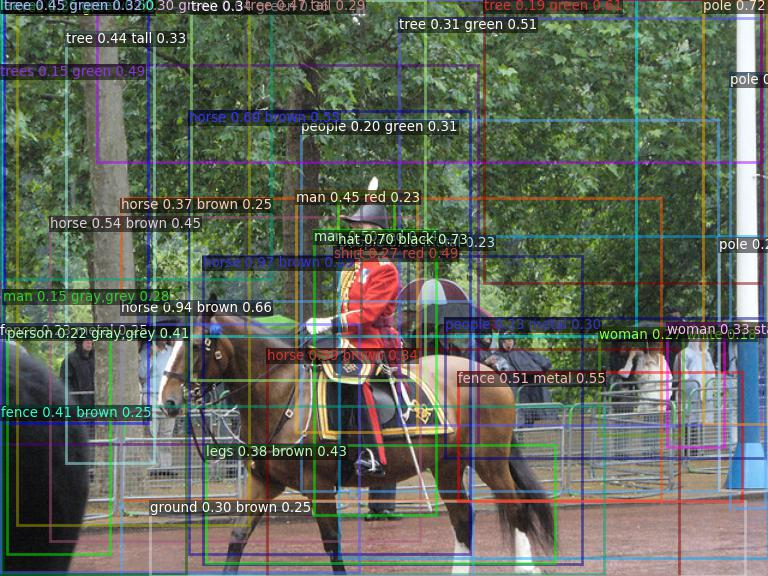

In [14]:
# for visualizing output
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

#image viz
frcnn_visualizer = SingleImageViz(URL, id2obj=objids, id2attr=attrids)

frcnn_visualizer.draw_boxes(
    output_dict.get("boxes"),
    output_dict.pop("obj_ids"),
    output_dict.pop("obj_probs"),
    output_dict.pop("attr_ids"),
    output_dict.pop("attr_probs"),
)
showarray(frcnn_visualizer._get_buffer())

In [15]:
#Very important that the boxes are normalized
normalized_boxes = output_dict.get("normalized_boxes")
features = output_dict.get("roi_features")

# 모델 구성(2) LxmertTokenizer

In [16]:
lxmert_tokenizer = LxmertTokenizer.from_pretrained("unc-nlp/lxmert-base-uncased")

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [17]:
test_question = ["what is the man riding?"]

inputs = lxmert_tokenizer(
    test_question,
    padding="max_length",
    max_length=20,
    truncation=True,
    return_token_type_ids=True,
    return_attention_mask=True,
    add_special_tokens=True,
    return_tensors="pt"
)

In [18]:
print(inputs.input_ids)
print(inputs.attention_mask)

tensor([[ 101, 2054, 2003, 1996, 2158, 5559, 1029,  102,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


# 모델 구성(3) LxmertModel

In [19]:
lxmert_vqa = LxmertForQuestionAnswering.from_pretrained("unc-nlp/lxmert-vqa-uncased")

In [20]:
output_vqa = lxmert_vqa(
    input_ids=inputs.input_ids,
    attention_mask=inputs.attention_mask,
    visual_feats=features,
    visual_pos=normalized_boxes,
    token_type_ids=inputs.token_type_ids,
    output_attentions=False,
)

output_vqa

LxmertForQuestionAnsweringOutput(loss=None, question_answering_score=tensor([[-4.8003, -2.0933, -5.0623,  ..., -3.4784,  0.5502, -0.9368]],
       grad_fn=<AddmmBackward>), language_hidden_states=None, vision_hidden_states=None, language_attentions=None, vision_attentions=None, cross_encoder_attentions=None)

In [21]:
len(output_vqa["question_answering_score"][0])

3129

In [22]:
# get prediction
pred_vqa = output_vqa["question_answering_score"].argmax(-1)

pred_vqa

tensor([315])

In [23]:
vqa_answers[315]

'horse'

In [24]:
print("Question:", test_question)
print("prediction from LXMERT VQA:", vqa_answers[pred_vqa])

Question: ['what is the man riding?']
prediction from LXMERT VQA: horse


# VQA Inference

In [25]:
test_questions_for_url1 = [
    "Where is this scene?",
    "what is the man riding?",
    "What is the man wearing?",
    "What is the color of the horse?"
]

for test_question in test_questions_for_url1:
    # run lxmert
    test_question = [test_question]

    inputs = lxmert_tokenizer(
        test_question,
        padding="max_length",
        max_length=20,
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"
    )

    # run lxmert(s)
    output_vqa = lxmert_vqa(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        visual_feats=features,
        visual_pos=normalized_boxes,
        token_type_ids=inputs.token_type_ids,
        output_attentions=False,
    )
    # get prediction
    pred_vqa = output_vqa["question_answering_score"].argmax(-1)
    print("Question:", test_question)
    print("prediction from LXMERT VQA:", vqa_answers[pred_vqa])

Question: ['Where is this scene?']
prediction from LXMERT VQA: outdoors
Question: ['what is the man riding?']
prediction from LXMERT VQA: horse
Question: ['What is the man wearing?']
prediction from LXMERT VQA: suit
Question: ['What is the color of the horse?']
prediction from LXMERT VQA: brown


# 프로젝트 : GQA 모델 활용하기

## Step 1. 다른 이미지 테스트해 보기

In [1]:
# 오늘 실습을 위한 작업디렉토리로 이동합니다.
!cd ~/aiffel/lxmert

from IPython.display import clear_output, Image, display
import PIL.Image
import io
import json
import torch
import numpy as np
from transformers import LxmertForQuestionAnswering, LxmertTokenizer
import wget
import pickle
import os, sys

# 추가해준 모듈을 임포트하기 위해 아래 경로를 path에 추가합니다. 
sys.path.append(os.getenv('HOME')+'/aiffel/lxmert')
from processing_image import Preprocess
from visualizing_image import SingleImageViz
from modeling_frcnn import GeneralizedRCNN
from utils import Config
import utils

print(torch.__version__)

1.8.1+cu102


In [2]:
# object definition
OBJ_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/objects_vocab.txt"
objids = utils.get_data(OBJ_URL)
print(len(objids))
print(objids[:30])  #1600개의 단어사전 중 30개만 출력

1600
['yolk', 'goal', 'bathroom', 'macaroni', 'umpire', 'toothpick', 'alarm clock', 'ceiling fan', 'photos', 'parrot', 'tail fin', 'birthday cake', 'calculator', 'catcher', 'toilet', 'batter', 'stop sign,stopsign', 'cone', 'microwave,microwave oven', 'skateboard ramp', 'tea', 'dugout', 'products', 'halter', 'kettle', 'kitchen', 'refrigerator,fridge', 'ostrich', 'bathtub', 'blinds']


In [3]:
# attribute definition
ATTR_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/attributes_vocab.txt"
attrids = utils.get_data(ATTR_URL)
print(len(attrids))
print(attrids[:30])   #400개의 단어사전 중 30개만 출력

400
['gray,grey', 'multi colored,multi-colored,multicolored', 'double decker,double-decker', 'unmade', 'red', 'camouflage', 'blue', 'white', 'green', 'pink', 'yellow', 'black', 'ivory', 'throwing', 'orange', 'spiky', 'plaid', 'purple', 'soccer', 'brake', 'blonde', 'american', 'flat screen', 'brown', 'wooden', 'performing', 'pulled back', 'windshield', 'bald', 'chocolate']


In [4]:
# VQA answer definition
VQA_URL = "https://raw.githubusercontent.com/airsplay/lxmert/master/data/vqa/trainval_label2ans.json"
vqa_answers = utils.get_data(VQA_URL)
print(len(vqa_answers))
print(vqa_answers[:30])  #3129개의 단어사전 중 30개만 출력

3129
['', 'woods', 'trash can', 'hanging', 'wooden', 'cooking', 'china', 'kids', 'bike rack', 'on phone', 'music', 'travel', 'tulip', 'arrow', 'branch', 'chevron', 'mouth', 'on right', 'rice', 'plate', 'lots', 'nature', 'fruits', 'throwing frisbee', 'blonde', 'life jacket', 'ham', 'hay', 'hat', 'to get to other side']


In [5]:
# 위 이미지의 URL
URL = "https://vqa.cloudcv.org/media/test2014/COCO_test2014_000000262567.jpg"

frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")
image_preprocess = Preprocess(frcnn_cfg)

images, sizes, scales_yx = image_preprocess(URL)

loading configuration file cache


In [6]:
print(images)
print(sizes)

tensor([[[[  61.0199,   61.2689,   62.1015,  ...,   50.5607,   50.1444,
             50.0199],
          [  60.8955,   61.1445,   61.9771,  ...,   50.8094,   50.3931,
             50.2686],
          [  60.4793,   60.7282,   61.5609,  ...,   51.6420,   51.2256,
             51.1012],
          ...,
          [ -87.9801,  -88.0373,  -88.2285,  ...,   21.7716,   21.5466,
             21.4793],
          [ -87.9801,  -88.0891,  -88.4536,  ...,   21.9628,   21.9110,
             21.8955],
          [ -87.9801,  -88.1046,  -88.5209,  ...,   22.0199,   22.0199,
             22.0199]],

         [[  48.0535,   48.4269,   49.6759,  ...,   41.5943,   41.1780,
             41.0535],
          [  47.9291,   48.2871,   49.4843,  ...,   41.5943,   41.1780,
             41.0535],
          [  47.5129,   47.8190,   48.8429,  ...,   41.5943,   41.1780,
             41.0535],
          ...,
          [ -99.9465,  -99.9364,  -99.9026,  ...,   13.8052,   13.5802,
             13.5129],
          [ -99.94

In [8]:
test_questions_for_url2 = [
    "Where is the cat?",
    "What is near the disk?",
    "What is the color of the table?",
    "What is the color of the cat?",
    "What is the shape of the monitor?",
    "What is the color of the keyboard?",
]

In [9]:
frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")

frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=frcnn_cfg)

loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /home/aiffel-dj20/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.


In [10]:
frcnn_cfg.max_detections  # object detection 모델이 검출할 최대 object 개수

36

In [11]:
output_dict = frcnn(
    images, 
    sizes, 
    scales_yx=scales_yx, 
    padding="max_detections",
    max_detections=frcnn_cfg.max_detections,
    return_tensors="pt"
)

In [12]:
print(output_dict.get("boxes"))
print('-------------')
print(output_dict.get("boxes").shape)

tensor([[[1.0372e+02, 1.3613e+02, 2.2735e+02, 1.6974e+02],
         [8.4005e+01, 1.1941e+02, 2.4814e+02, 1.7585e+02],
         [0.0000e+00, 8.1354e+01, 3.2642e+02, 2.6568e+02],
         [3.8475e+02, 3.7221e+01, 4.9974e+02, 3.3300e+02],
         [2.9875e+01, 0.0000e+00, 4.3054e+02, 1.3465e+02],
         [1.5929e+02, 9.1682e+01, 3.7275e+02, 2.4955e+02],
         [6.7672e-01, 2.4750e+02, 2.7701e+02, 3.3300e+02],
         [1.6578e+02, 1.2526e+02, 3.4723e+02, 2.1946e+02],
         [0.0000e+00, 7.1275e+01, 2.1836e+02, 3.0790e+02],
         [5.2669e+01, 1.7062e+00, 2.6646e+02, 1.8314e+02],
         [6.1805e+01, 2.4761e+02, 4.2838e+02, 3.3299e+02],
         [1.2076e+01, 1.1892e+02, 3.6657e+02, 3.0462e+02],
         [1.9641e+02, 1.0624e+02, 3.5971e+02, 1.9710e+02],
         [9.1356e+01, 1.1064e+02, 4.1889e+02, 2.8040e+02],
         [1.2139e+02, 1.0626e+01, 4.8306e+02, 1.6577e+02],
         [3.0271e+02, 1.0307e+02, 3.2805e+02, 1.2879e+02],
         [2.9658e+02, 5.5949e+00, 4.9991e+02, 2.7482e+02

In [13]:
print(output_dict.get("roi_features"))
print('-------------')
print(output_dict.get("roi_features").shape)

tensor([[[2.4822e-03, 2.3580e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 3.3088e+00],
         [2.6639e-01, 1.0124e+00, 0.0000e+00,  ..., 9.0339e-04,
          1.5285e-02, 3.0090e+00],
         [6.0975e-01, 0.0000e+00, 0.0000e+00,  ..., 1.0956e-01,
          2.5223e-01, 1.7357e+00],
         ...,
         [7.9118e-01, 2.3213e-01, 0.0000e+00,  ..., 2.2883e-02,
          7.2807e-03, 6.4609e-01],
         [0.0000e+00, 1.4173e+00, 0.0000e+00,  ..., 0.0000e+00,
          2.0937e+00, 1.9630e+00],
         [1.0801e+00, 8.3446e-01, 0.0000e+00,  ..., 1.2504e-02,
          3.0912e-01, 6.6703e-01]]])
-------------
torch.Size([1, 36, 2048])


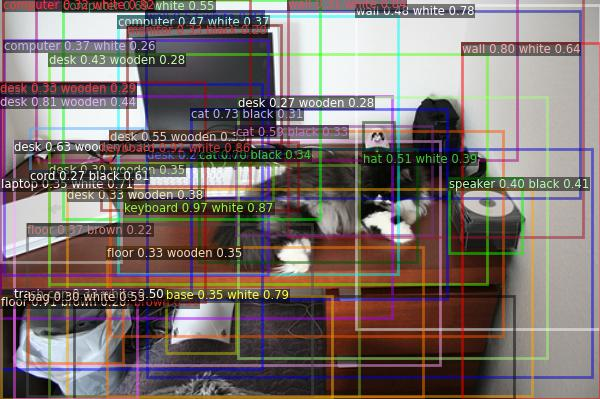

In [14]:
# for visualizing output
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

#image viz
frcnn_visualizer = SingleImageViz(URL, id2obj=objids, id2attr=attrids)

frcnn_visualizer.draw_boxes(
    output_dict.get("boxes"),
    output_dict.pop("obj_ids"),
    output_dict.pop("obj_probs"),
    output_dict.pop("attr_ids"),
    output_dict.pop("attr_probs"),
)
showarray(frcnn_visualizer._get_buffer())

In [15]:
#Very important that the boxes are normalized
normalized_boxes = output_dict.get("normalized_boxes")
features = output_dict.get("roi_features")

In [16]:
lxmert_tokenizer = LxmertTokenizer.from_pretrained("unc-nlp/lxmert-base-uncased")

In [17]:
test_question = ["what is the man riding?"]

inputs = lxmert_tokenizer(
    test_question,
    padding="max_length",
    max_length=20,
    truncation=True,
    return_token_type_ids=True,
    return_attention_mask=True,
    add_special_tokens=True,
    return_tensors="pt"
)

In [18]:
print(inputs.input_ids)
print(inputs.attention_mask)

tensor([[ 101, 2054, 2003, 1996, 2158, 5559, 1029,  102,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


In [19]:
lxmert_vqa = LxmertForQuestionAnswering.from_pretrained("unc-nlp/lxmert-vqa-uncased")

In [20]:
output_vqa = lxmert_vqa(
    input_ids=inputs.input_ids,
    attention_mask=inputs.attention_mask,
    visual_feats=features,
    visual_pos=normalized_boxes,
    token_type_ids=inputs.token_type_ids,
    output_attentions=False,
)

output_vqa

LxmertForQuestionAnsweringOutput(loss=None, question_answering_score=tensor([[-8.8629, -2.9882,  1.2814,  ..., -4.9313,  0.6163, -1.6971]],
       grad_fn=<AddmmBackward>), language_hidden_states=None, vision_hidden_states=None, language_attentions=None, vision_attentions=None, cross_encoder_attentions=None)

In [21]:
len(output_vqa["question_answering_score"][0])

3129

In [22]:
# get prediction
pred_vqa = output_vqa["question_answering_score"].argmax(-1)

pred_vqa

tensor([1770])

In [23]:
vqa_answers[315]

'horse'

In [24]:
print("Question:", test_question)
print("prediction from LXMERT VQA:", vqa_answers[pred_vqa])

Question: ['what is the man riding?']
prediction from LXMERT VQA: cat


In [25]:
test_questions_for_url1 = [
    "Where is the cat?",
    "What is near the disk?",
    "What is the color of the table?",
    "What is the color of the cat?",
    "What is the shape of the monitor?",
    "What is the color of the keyboard?"
]

for test_question in test_questions_for_url1:
    # run lxmert
    test_question = [test_question]

    inputs = lxmert_tokenizer(
        test_question,
        padding="max_length",
        max_length=20,
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"
    )

    # run lxmert(s)
    output_vqa = lxmert_vqa(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        visual_feats=features,
        visual_pos=normalized_boxes,
        token_type_ids=inputs.token_type_ids,
        output_attentions=False,
    )
    # get prediction
    pred_vqa = output_vqa["question_answering_score"].argmax(-1)
    print("Question:", test_question)
    print("prediction from LXMERT VQA:", vqa_answers[pred_vqa])

Question: ['Where is the cat?']
prediction from LXMERT VQA: desk
Question: ['What is near the disk?']
prediction from LXMERT VQA: cat
Question: ['What is the color of the table?']
prediction from LXMERT VQA: brown
Question: ['What is the color of the cat?']
prediction from LXMERT VQA: black and white
Question: ['What is the shape of the monitor?']
prediction from LXMERT VQA: rectangle
Question: ['What is the color of the keyboard?']
prediction from LXMERT VQA: white


## GQA 데이터셋 버전 모델 테스트해 보기

In [ ]:
# 오늘 실습을 위한 작업디렉토리로 이동합니다.
!cd ~/aiffel/lxmert

from IPython.display import clear_output, Image, display
import PIL.Image
import io
import json
import torch
import numpy as np
from transformers import LxmertForQuestionAnswering, LxmertTokenizer
import wget
import pickle
import os, sys

# 추가해준 모듈을 임포트하기 위해 아래 경로를 path에 추가합니다. 
sys.path.append(os.getenv('HOME')+'/aiffel/lxmert')
from processing_image import Preprocess
from visualizing_image import SingleImageViz
from modeling_frcnn import GeneralizedRCNN
from utils import Config
import utils

print(torch.__version__)

In [ ]:
# object definition
OBJ_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/objects_vocab.txt"
objids = utils.get_data(OBJ_URL)
print(len(objids))
print(objids[:30])  #1600개의 단어사전 중 30개만 출력

In [ ]:
# attribute definition
ATTR_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/attributes_vocab.txt"
attrids = utils.get_data(ATTR_URL)
print(len(attrids))
print(attrids[:30])   #400개의 단어사전 중 30개만 출력

In [28]:
# GQA answer definition
GQA_URL = "https://raw.githubusercontent.com/airsplay/lxmert/master/data/gqa/trainval_label2ans.json"
gqa_answers = utils.get_data(GQA_URL)
print(len(vqa_answers))
print(vqa_answers[:30])  #3129개의 단어사전 중 30개만 출력

3129
['', 'woods', 'trash can', 'hanging', 'wooden', 'cooking', 'china', 'kids', 'bike rack', 'on phone', 'music', 'travel', 'tulip', 'arrow', 'branch', 'chevron', 'mouth', 'on right', 'rice', 'plate', 'lots', 'nature', 'fruits', 'throwing frisbee', 'blonde', 'life jacket', 'ham', 'hay', 'hat', 'to get to other side']


In [29]:
# 위 이미지의 URL
URL = "https://vqa.cloudcv.org/media/test2014/COCO_test2014_000000262567.jpg"

l
image_preprocess = Preprocess(lxmert_gqa)

images, sizes, scales_yx = image_preprocess(URL)

AttributeError: 'LxmertForQuestionAnswering' object has no attribute 'INPUT'

# Step 3. 내가 선택한 이미지로 VQA/GQA 버전 비교해 보기


# 루브릭 평가

|평가문항|상세기준|
|:----|:----|
|1. LXMERT 모델을 활용해 새로운 이미지에 대한 VQA 작업을 진행하였다.|이미지 bounding box 시각화 및 question에 대한 answer 출력이 정상적으로 진행되었다.|
|2. GQA 버전의 LXMERT 모델을 활용해 VQA 작업을 진행하였다.|GQA 버전 모델을 활용하여 question에 대한 answer 출력이 정상적으로 진행되었다.|
|3. VQA, GQA 버전의 성능을 체계적으로 비교분석하였다.|자신이 선택한 다양한 이미지에 대해 두 모델의 답안이 어떻게 달라지는지 비교분석 결과를 제출하였다.|

1. 새로운 이미지에 대한 VQA 작업을 진행했다. 이미지만 바꿨는데, 바운딩박스가 알아서 그려지고 라벨링이 된다는 것이 신기했다.


2,3은 시도 도중에 에러가 났다. 

# 회고

아이펠 노드가 끝났다. 유종의 미를 거두고 싶었지만 뒤로 갈수록 시간도 없고 흥미도 떨어졌다. 시원섭섭한 마음이다. 


부족한 노드 항상 읽어주셔서 감사합니다. 퍼실님들!